# Upon business model analysis using data from fashionphile.com

In [430]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso
from sklearn.ensemble import RandomForestRegressor as RDFR
from sklearn.ensemble import RandomForestClassifier as RDFC
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler

import math

%matplotlib inline

In [516]:
# import data
df = pd.read_csv('data2.csv')
df.head(n = 3)

,id,name,brand,url,price,retail,original,buyback,bag,like,sold,condition,listed_date,sold_date
0,10001,Fashionphile eGift Card,Fashionphile SWAG,https://www.fashionphile.com/fashionphile-egif...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,2018-11-22,NaN
1,10002,FASHIONPHILE Handbag Calendar,Fashionphile SWAG,https://www.fashionphile.com/fashionphile-hand...,NaN,NaN,NaN,NaN,NaN,NaN,True,New,2018-11-22,2018-11-17
2,10004,FASHIONPHILE Pet Picks Calendar,Fashionphile SWAG,https://www.fashionphile.com/fashionphile-pet-...,NaN,NaN,NaN,NaN,NaN,NaN,True,New,2018-11-22,2018-11-17


### Data pre-processing

In [292]:
# df['brand'].unique()

In [517]:
# Drop irrelevant brands that are not bags, drop url column
df = df.drop(['url'], axis = 1)
not_bag = ['Fashionphile SWAG', 'Christian Louboutin', 'Chopard','David Yurman', 'Tiffany', 'Cartier',
          'Van Cleef & Arpels', 'Mikimoto', 'Tom Ford', 'Bulgari', 'Harry Winston', 'Rolex',
          'Judith Ripka', 'Oliver Peoples', 'Patek Philippe', 'John Hardy', 'Panerai', 'Omega',
          'Manolo Blahnik', 'IWC']
for name in not_bag:
    df = df[df['brand'] != name].copy()

In [518]:
# summary of data
print('Total number of listed items:', df.shape[0])
print('Items with price information:', df[df['price'].notnull()].shape[0])
print('Items with both price and retail information:', 
      df[df['price'].notnull() & df['retail'].notnull()].shape[0])
print('Items sold between 2018-11-17 and 2018-12-19:', 
      df[df['sold']==True & (df['sold_date']!='2018-11-17')].shape[0])
print('Items not yet sold:', df[df['sold'].isnull()].shape[0])

Total number of listed items: 253735
Items with price information: 14373
Items with both price and retail information: 9189
Items sold between 2018-11-17 and 2018-12-19: 8645
Items not yet sold: 6568


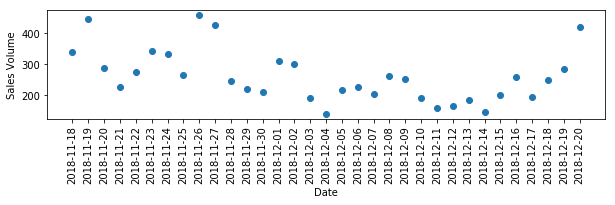

In [519]:
# dates of sales we tracked
sales_dates = df[df['sold'] == True & (df['sold_date']!='2018-11-17')]['sold_date'].unique()

# sales volume by day
sales_volume = {} #create an empty dict to store sales volume every two days
for i in sales_dates:
    sales_volume[i] = df[df['sold']==True & (df['sold_date']==i)].shape[0]
sales_volume_df = df.from_dict(sales_volume, orient='index', columns=['volume'])
sales_volume_df.sort_index(inplace=True)

# print('Sale volume by date:\n', sales_volume_df) 
plt.figure(figsize=(10,2))
plt.plot(sales_volume_df, 'o')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.show()

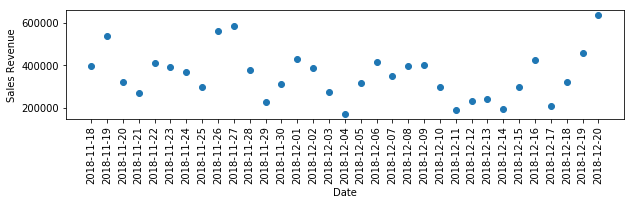

In [520]:
# total sales revenue by date
sales_revenue = {}
for i in sales_dates:
    sales_revenue[i] = df[df['sold']==True & (df['sold_date']==i)]['price'].sum(skipna = True).round()
sales_revenue_df = df.from_dict(sales_revenue, orient='index', columns=['revenue'])
sales_revenue_df.sort_index(inplace=True)

# print('Sales revenue by date\n', sales_revenue_df)
plt.figure(figsize=(10,2))
plt.plot(sales_revenue_df, 'o')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Sales Revenue')
plt.show()

In [521]:
daily_volume = round(sales_volume_df.values.sum()/33, 2)
daily_revenue = round(sales_revenue_df.values.sum()/33, 2)
print('Average sales volume per day:', daily_volume)
print('Average revenue per day:', daily_revenue)

Average sales volume per day: 261.97
Average revenue per day: 354613.48


# Brand Populatiry Analysis
### Overall popularity by brand

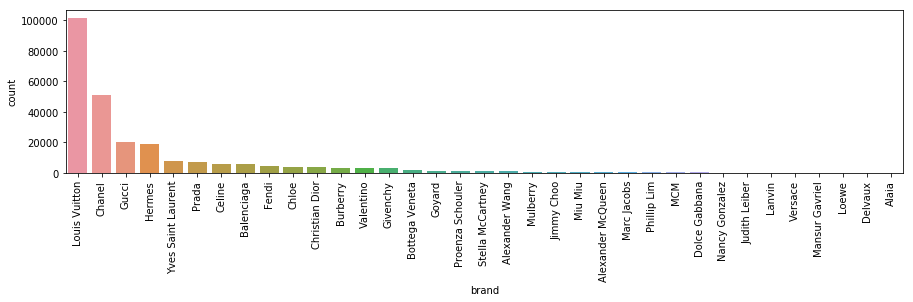

In [522]:
# Overall popularity sold+available
f, (ax1) = plt.subplots(1,1, figsize = (15, 3))
sns.countplot(x = df['brand'], data = df, ax = ax1, order = df['brand'].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

### Sold items

Total number of sold itmes: 247167


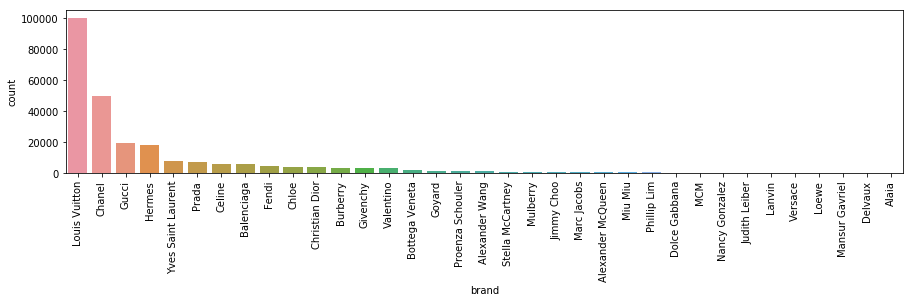

In [523]:
df_sold = df[df['sold']==True]
print('Total number of sold itmes:', df[df['sold']==True].shape[0])

f, (ax1) = plt.subplots(1,1, figsize = (15, 3))
sns.countplot(x = df_sold['brand'], data = df_sold, ax = ax1, order = df_sold['brand'].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

### Available items

Total number of available itmes: 6568


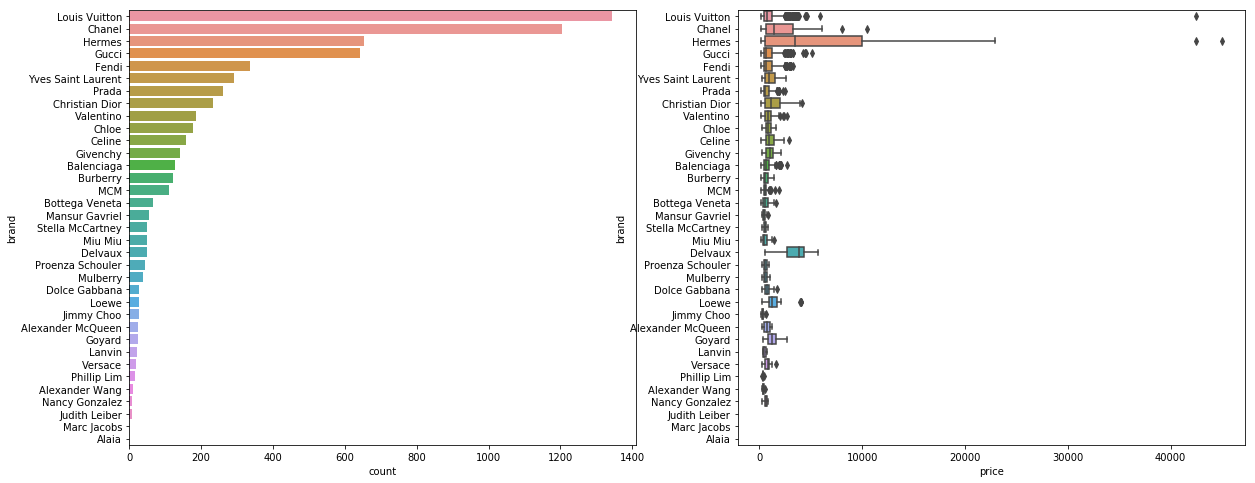

In [524]:
df_available = df[df['sold'].isnull()]
print('Total number of available itmes:', df[df['sold'].isnull()].shape[0])

f, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 8))
sns.countplot(y = df_available['brand'], data = df_available, ax = ax1, 
              order = df_available['brand'].value_counts().index)
sns.boxplot(y = df_available['brand'], x = df_available['price'], data = df_available, ax = ax2, 
            order = df_available['brand'].value_counts().index)
# plt.xticks(rotation = 90)
plt.show()

Both sold and available itmes follows the same popularity trend. 

In [525]:
# counting brand popularity
brand_popularity_percentage = pd.DataFrame(df['brand'].value_counts()/df['brand'].shape[0])
brand_popularity_percentage.head()

,brand
Louis Vuitton,0.400788
Chanel,0.200670
Gucci,0.078771
Hermes,0.074211
Yves Saint Laurent,0.030622


### Popularity by item

In [526]:
df['name'].describe()

count                               253735
unique                               98135
top       LOUIS VUITTON Monogram Speedy 30
freq                                   872
Name: name, dtype: object

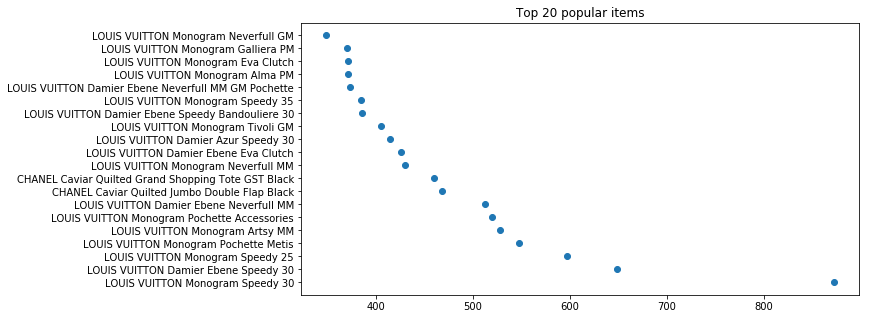

In [527]:
df_popular = pd.DataFrame(df['name'].value_counts())
plt.figure(figsize=(10,5))
plt.plot(df_popular[:20].values, df_popular[:20].index, 'o')
plt.title('Top 20 popular items')
plt.show()

In [528]:
name_popularity_percentage = pd.DataFrame(df['name'].value_counts()/df['name'].shape[0])
name_popularity_percentage.head()

,name
LOUIS VUITTON Monogram Speedy 30,0.003437
LOUIS VUITTON Damier Ebene Speedy 30,0.002558
LOUIS VUITTON Monogram Speedy 25,0.002353
LOUIS VUITTON Monogram Pochette Metis,0.002160
LOUIS VUITTON Monogram Artsy MM,0.002081


### Adding item and brand popularity column to dataframe based on frequency of item

In [529]:
# adding a popularity column to dataframe
df['item_popularity'] = df.groupby('name')['name'].transform('count')/df['name'].shape[0]
df['brand_popularity'] = df.groupby('brand')['brand'].transform('count')/df['brand'].shape[0]

In [530]:
df.head()

,id,name,brand,price,retail,original,buyback,bag,like,sold,condition,listed_date,sold_date,item_popularity,brand_popularity
3,10073,BOTTEGA VENETA Leather Wing Tip Flats 35 Nero,Bottega Veneta,NaN,NaN,NaN,NaN,NaN,NaN,True,Good,2018-11-22,2018-11-17,0.000008,0.008213
4,10074,GUCCI Logo Sunglasses 130 1430/S Gray,Gucci,NaN,NaN,NaN,NaN,NaN,NaN,True,Good,2018-11-22,2018-11-17,0.000004,0.078771
5,10075,MARC JACOBS Denim Rocker Black,Marc Jacobs,NaN,NaN,NaN,NaN,NaN,NaN,True,Excellent,2018-11-22,2018-11-17,0.000008,0.002810
6,10076,PRADA Leather Antic Black,Prada,NaN,NaN,NaN,NaN,NaN,NaN,True,Good,2018-11-22,2018-11-17,0.000004,0.028668
7,10077,LOUIS VUITTON Epi Sarah Wallet Porte-Monnaie C...,Louis Vuitton,NaN,NaN,NaN,NaN,NaN,NaN,True,Good,2018-11-22,2018-11-17,0.000004,0.400788


# Constructing a daily bucket of goods
Suppose on average we sell `daily_volume` of items. Using brand popularity, determine how many bags from each brand do we sell. Using item popularity table, determine what items and how many of them we sell in each brand every day. First return a list of names `bucket_items`. Then return a full table with more information `bucket_full {names, brand, popularity, like, bag, retail}`.

In [531]:
bucket_brand_volume = round(brand_popularity_percentage * daily_volume)
bucket_brand_volume[:15]

,brand
Louis Vuitton,105.0
Chanel,53.0
Gucci,21.0
Hermes,19.0
Yves Saint Laurent,8.0
Prada,8.0
Celine,6.0
Balenciaga,6.0
Fendi,5.0
Chloe,4.0


### Constructing `bucket_items`

In [532]:
# bucket_brand_volume.loc['Louis Vuitton', 'brand']
bucket_items = []
for b in bucket_brand_volume.index:
    units = (bucket_brand_volume.loc[b, 'brand'])
    for i in range(int(units)): 
        bucket_items.append(df[df['brand'] == b].sort_values('item_popularity', 
                         ascending = False).drop_duplicates('item_popularity').iloc[i]['name'])

In [533]:
bucket_items[:5]

['LOUIS VUITTON Monogram Speedy 30',
 'LOUIS VUITTON Damier Ebene Speedy 30',
 'LOUIS VUITTON Monogram Speedy 25',
 'LOUIS VUITTON Monogram Pochette Metis',
 'LOUIS VUITTON Monogram Artsy MM']

### Constructing `bucket_full_ready`, this is used to predict price using the price prediction model built below

In [534]:
bucket_full = pd.DataFrame(columns=['name','brand','retail','like','bag','brand_popularity','item_popularity'])

In [535]:
bucket_full['name'] = bucket_items

In [536]:
# fill in brand information
b = df.set_index('name')['brand']
b = b[~b.index.duplicated(keep='first')]
bucket_full['brand'] = bucket_full['brand'].fillna(bucket_full['name'].map(b))

In [537]:
# fill in retail information using data containing retail and price information
df_retail = df[df['retail'].notnull()].copy()
r = df_retail.set_index('name')['retail']
r = r[~r.index.duplicated(keep='first')]
bucket_full['retail'] = bucket_full['retail'].fillna(bucket_full['name'].map(r)).fillna('1500') ######### arbitrary
# bucket_full['retail'] = bucket_full['retail'].fillna(bucket_full['name'].map(r))

In [538]:
# fill in brand popularity 
bp = df.set_index('name')['brand_popularity']
bp = bp[~bp.index.duplicated(keep='first')]
bucket_full['brand_popularity'] = bucket_full['brand_popularity'].fillna(bucket_full['name'].map(bp))

In [539]:
# fill in item popularity 
ip = df.set_index('name')['item_popularity']
ip = ip[~ip.index.duplicated(keep='first')]
bucket_full['item_popularity'] = bucket_full['item_popularity'].fillna(bucket_full['name'].map(ip))

In [540]:
# fill in like information
df_like = df[df['like'].notnull()]
df_like_grouped = df_like.groupby('name')
df_like_mean = df_like_grouped.agg({'like': [np.mean]})
l = df_like_mean.set_index(df_like_mean.index)['like']['mean']
bucket_full['like'] = bucket_full['like'].fillna(bucket_full['name'].map(l)).fillna(30) ##### arbitrary

In [541]:
# fill in bag information
df_bag = df[df['bag'].notnull()]
df_bag_grouped = df_bag.groupby('name')
df_bag_mean = df_bag_grouped.agg({'bag': [np.mean]})
bag = df_bag_mean.set_index(df_bag_mean.index)['bag']['mean']
bucket_full['bag'] = bucket_full['bag'].fillna(bucket_full['name'].map(bag)).fillna(20)

In [542]:
df_price = df[df['price'].notnull()]
df_price_retail = df_price[df_price['retail'].notnull()].copy()

# convert brand to dummy columns 
dummies = pd.get_dummies(bucket_full['brand'])
a = dummies.columns.values
b = pd.get_dummies(df_price_retail['brand']).columns
dummies_extra = set(a)^set(b)
bucket_full_brands = pd.concat([dummies, pd.DataFrame(columns=dummies_extra)], axis = 1).sort_index(axis=1).fillna(0)

# create bucket_full_condition column with 5 
bucket_full_condition = pd.DataFrame(columns = ['condition'], index = bucket_full.index).fillna(5)

In [543]:
# bucket_full_ready is ready to be used for prediction using model 
bucket_full_ready_name = pd.concat([bucket_full.name, 
                                    bucket_full.retail.str.replace(',', '').astype(float).apply(np.log),
                                    bucket_full.bag,
                                    bucket_full.like,
                                    bucket_full_condition,
                                    bucket_full.item_popularity,
                                    bucket_full.brand_popularity,
                                    bucket_full_brands], axis = 1)
bucket_full_ready_name.shape

(263, 41)

In [544]:
bucket_full_ready = bucket_full_ready_name.drop(['name'], axis = 1)
bucket_full_ready.shape

(263, 40)

In [545]:
#standardize
bucket_full_ready_temp = bucket_full_ready.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = preprocessing.RobustScaler()
bucket_full_ready_scaled = min_max_scaler.fit_transform(bucket_full_ready_temp)
bucket_full_ready_std = pd.DataFrame(bucket_full_ready_scaled, columns=bucket_full_ready.columns.values)

In [546]:
bucket_full_ready_std['condition'].replace(to_replace=0, value=1, inplace=True)

In [547]:
bucket_full_ready_std.head()

,retail,bag,like,condition,item_popularity,brand_popularity,Alexander McQueen,Alexander Wang,Balenciaga,Bottega Veneta,...,Miu Miu,Mulberry,Nancy Gonzalez,Phillip Lim,Prada,Proenza Schouler,Stella McCartney,Valentino,Versace,Yves Saint Laurent
0,-0.776866,-0.237425,-0.346908,1.0,5.710037,0.612775,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.776866,-0.228870,-0.075415,1.0,4.052045,0.612775,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.816756,0.164701,-0.110608,1.0,3.665428,0.612775,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.400559,0.068209,1.228649,1.0,3.301115,0.612775,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.579498,0.190368,-0.202289,1.0,3.152416,0.612775,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [548]:
np.sum(np.sum(bucket_full_ready_std.isnull()))

0

# Pricing model
To predict sales price using brand, name, retail, bag, like, sold, condition, list_length

In [549]:
# entires with both sale price and retail price information 
df_price = df_price[df_price['price'].notnull()]
df_price_retail = df_price[df_price['retail'].notnull()].copy()
df_price_retail.shape

(9189, 15)

### Price distribution by brands: Louis Vuitton, Chanel, Hermes

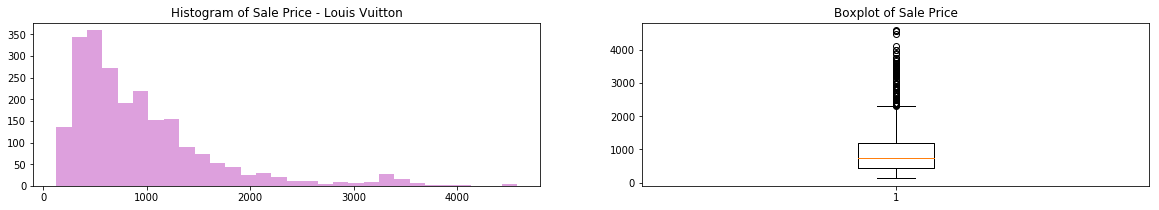

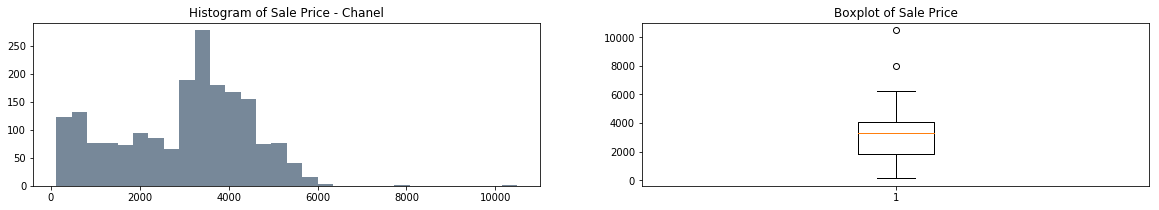

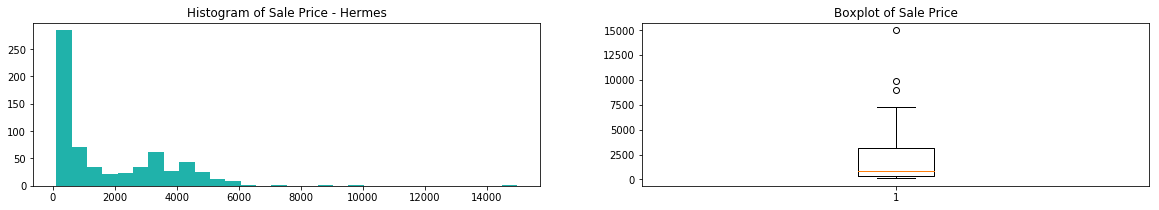

In [550]:
# Louis Vuitton
df_LV = df_price_retail[df_price_retail['brand'] == 'Louis Vuitton']

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 3))
ax1.hist(df_LV['price'], bins=30, color='plum')
ax2.boxplot(df_LV['price'])

ax1.set_title("Histogram of Sale Price - Louis Vuitton")
ax2.set_title("Boxplot of Sale Price")
plt.show()

# Chanel
df_chanel = df_price_retail[df_price_retail['brand'] == 'Chanel']

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 3))
ax1.hist(df_chanel['price'], bins=30, color='lightslategray')
ax2.boxplot(df_chanel['price'])

ax1.set_title("Histogram of Sale Price - Chanel")
ax2.set_title("Boxplot of Sale Price")
plt.show()

# Hermes
df_hermes = df_price_retail[df_price_retail['brand'] == 'Hermes']

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 3))
ax1.hist(df_hermes['price'], bins=30, color='lightseagreen')
ax2.boxplot(df_hermes['price'])

ax1.set_title("Histogram of Sale Price - Hermes")
ax2.set_title("Boxplot of Sale Price")
plt.show()

### Transform data to fit model

In [551]:
# map condition to rating scale
df_price_retail['condition'] = df_price_retail['condition'].map({'New': 5, 
                                                                 'Excellent': 4, 
                                                                 'Very Good': 3, 
                                                                 'Good': 2, 
                                                                 'Fair': 1})

In [552]:
# select relevant columns, convert to dummy variables, log transform retail and price
df_price_retail_dummy = pd.concat([df_price_retail.retail.str.replace(',', '').astype(float).apply(np.log),
                                   df_price_retail.bag.fillna(0),
                                   df_price_retail.like.fillna(0),
                                   df_price_retail.condition.fillna(0),
                                   df_price_retail.item_popularity.fillna(0),
                                   df_price_retail.brand_popularity.fillna(0),
                                   pd.get_dummies(df_price_retail['brand']),
                                   df_price_retail.price.astype(float).apply(np.log)], axis = 1)
df_price_retail_dummy.shape

(9189, 41)

In [553]:
df_price_retail_dummy = df_price_retail_dummy[df_price_retail_dummy['retail']!=-np.inf]
df_price_retail_dummy.shape

(9186, 41)

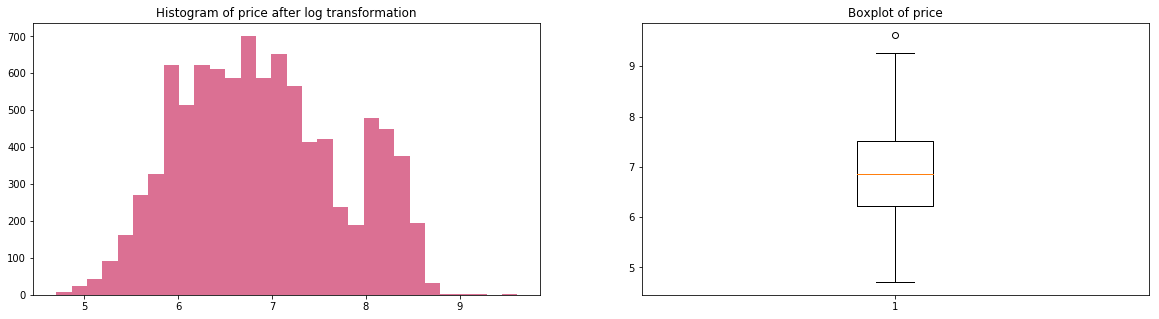

In [554]:
# training and testing datasets
x = df_price_retail_dummy.drop(['price'], axis = 1)
y = df_price_retail_dummy['price']

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.hist(y, bins=30, color='palevioletred')
ax2.boxplot(y)
ax1.set_title("Histogram of price after log transformation")
ax2.set_title("Boxplot of price")
plt.show()

# standardize
x_temp = x.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = preprocessing.RobustScaler()
x_scaled = min_max_scaler.fit_transform(x_temp)
x = pd.DataFrame(x_scaled, columns=x.columns.values)

x_train = x[:6000]
y_train = y[:6000]

x_test = x[6000:]
y_test = y[6000:]

In [555]:
x.head() ## retail is log trasformed, all values standardized [0,1]

,retail,bag,like,condition,item_popularity,brand_popularity,Alexander McQueen,Alexander Wang,Balenciaga,Bottega Veneta,...,Miu Miu,Mulberry,Nancy Gonzalez,Phillip Lim,Prada,Proenza Schouler,Stella McCartney,Valentino,Versace,Yves Saint Laurent
0,0.427945,0.375,2.833333,-1.0,-0.058824,-0.269709,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.228159,1.000,-0.333333,0.0,-0.176471,-0.357264,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.967322,-0.375,0.452381,-2.0,-0.176471,-0.337727,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.019150,-0.625,-0.142857,-1.0,-0.058824,-0.423538,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.009734,0.125,0.309524,-1.0,-0.058824,-0.365742,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Ordinary Linear Regression

R^2 is: 0.895822295234163


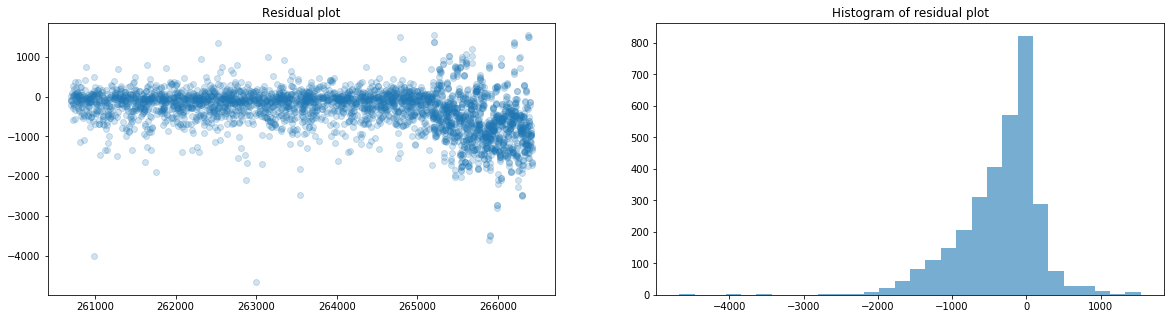

In [556]:
model = Lin_Reg()
model.fit(x_train, y_train)

# print('Coeff is:', model.coef_ )
# print('Intercept is:', model.intercept_ )

score = model.score(x_test, y_test)
print('R^2 is:', score)

pred = model.predict(x_test)
diff = np.exp(pred) - np.exp(y_test)
f, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 5))
ax1.plot(diff, 'o', alpha = 0.2)
ax2.hist(diff, bins=30, alpha=0.6)
ax1.set_title('Residual plot')
ax2.set_title('Histogram of residual plot')
plt.show()

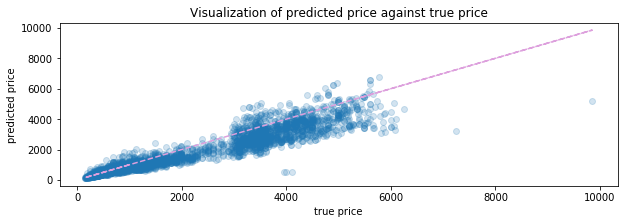

In [557]:
plt.figure(figsize=[10,3])
plt.plot(np.exp(y_test), np.exp(pred), 'o', alpha = 0.2)
plt.plot(np.exp(y_test), np.exp(y_test),'--', color = 'plum', )
plt.xlabel('true price')
plt.ylabel('predicted price')
plt.title('Visualization of predicted price against true price')
plt.show()

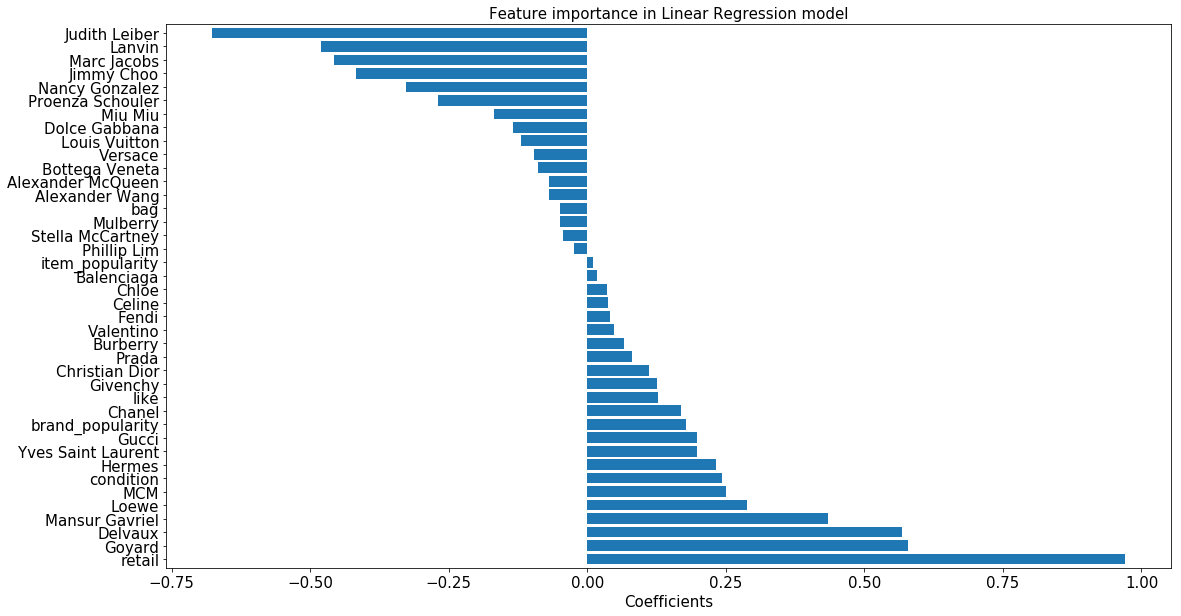

In [558]:
coef = pd.Series(model.coef_, index = x_train.columns)
newcoef = pd.DataFrame(coef)
newcoef_sorted = newcoef.sort_values(by=[0], ascending=False)

matplotlib.rcParams['figure.figsize'] = (18.0, 10.0)
newcoef_sorted.plot(kind = "barh", width = 0.8, legend=None, fontsize = 15)
plt.xlabel('Coefficients',fontsize = 15)
plt.title('Feature importance in Linear Regression model', fontsize = 15)
plt.show()

### Ridge Regression

In [559]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [560]:
# num_lambdas = 100
# lambdas= np.linspace(-2, 2, num_lambdas)

# cv_ridge = [cross_val_score(Ridge(alpha = 10**i), x_train, y_train, scoring = 'r2' , cv = 5).mean() 
#             for i in lambdas]

num_lambdas = 100
lambdas= np.linspace(-3,3, num_lambdas)
cv_ridge = [rmse_cv(Ridge(alpha = 10**i)).mean() 
            for i in lambdas]

Ridge Regression: min RMSE on training set 0.30905322601184215


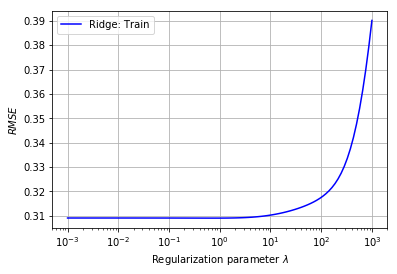

In [561]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.semilogx(10.0**lambdas, (cv_ridge), label='Ridge: Train')

# ax.set_xlabel('Regularization parameter $\lambda$')
# ax.set_ylabel('R2')

# ax.grid()
# ax.legend(loc = 'best')

# print ('Ridge Regression:  R^2 on training set', round(max(cv_ridge),4))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.semilogx(10.0**lambdas, (cv_ridge), c='b', label='Ridge: Train')
ax.set_xlabel('Regularization parameter $\lambda$')
ax.set_ylabel(r'$RMSE$')
ax.grid()
ax.legend(loc = 'best')

print('Ridge Regression: min RMSE on training set', min(cv_ridge))

In [562]:
# max_value = max(cv_ridge)
# max_index = cv_ridge.index(max_value)
# print("Lambda for max R2:", round(lambdas[max_index],4))

min_value = min(cv_ridge)
min_index = cv_ridge.index(min_value)
print("Lambda for min RMSE:", round(lambdas[min_index],4))

Lambda for min RMSE: -0.1515


In [563]:
# best_ridge = Ridge(alpha = 10**(lambdas[max_index])).fit(x_train, y_train)
best_ridge = Ridge(alpha = 10**(lambdas[min_index])).fit(x_train, y_train)

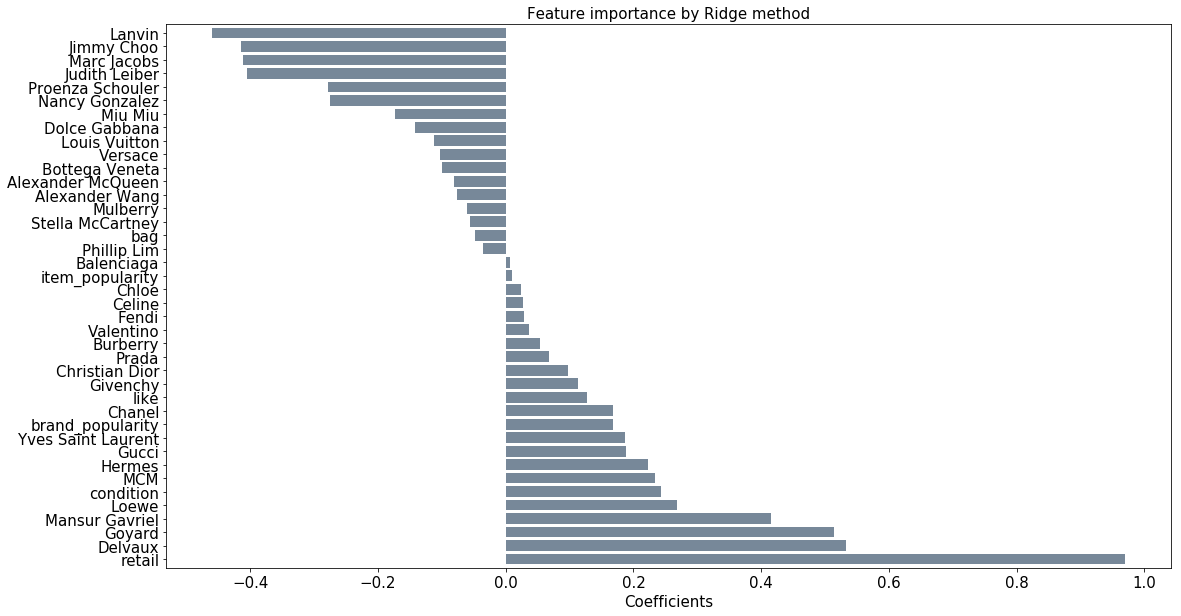

In [565]:
coef = pd.Series(best_ridge.coef_, index = x_train.columns)
newcoef = pd.DataFrame(coef)
newcoef_sorted = newcoef.sort_values(by=[0], ascending=[False])

matplotlib.rcParams['figure.figsize'] = (18.0, 10.0)
newcoef_sorted.plot(kind = "barh", width = 0.8, color = 'lightslategray', legend=None, fontsize = 15)
plt.xlabel('Coefficients',fontsize = 15)
plt.title('Feature importance by Ridge method', fontsize = 15)
plt.show()

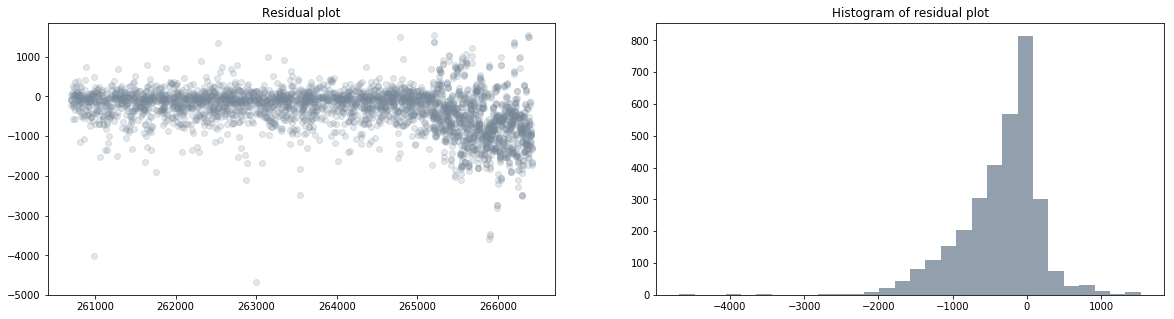

In [566]:
# Predict with our constructed Ridge model
pred = best_ridge.predict(x_test)
diff = np.exp(pred) - np.exp(y_test)

f, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 5))
ax1.plot(diff, 'o', color = 'lightslategray', alpha = 0.2)
ax2.hist(diff, bins=30, color = 'lightslategray', alpha = 0.8)
ax1.set_title('Residual plot')
ax2.set_title('Histogram of residual plot')
plt.show()

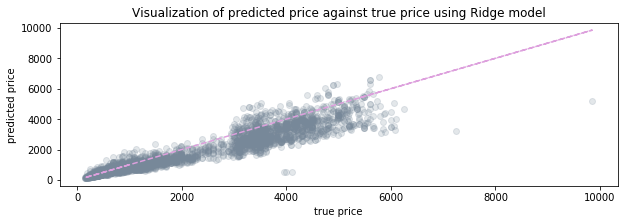

In [567]:
plt.figure(figsize=[10,3])
plt.plot(np.exp(y_test), np.exp(pred), 'o', color = 'lightslategray', alpha = 0.2)
plt.plot(np.exp(y_test), np.exp(y_test),'--', color = 'plum', )
plt.xlabel('true price')
plt.ylabel('predicted price')
plt.title('Visualization of predicted price against true price using Ridge model')
plt.show()

We are going to use the `best_ridge` model to predict sale prices. It takes in input in format of:

`{['name','retail','like','bag','brand_popularity','item_popularity', pd.get_dummies(df_price_retail['brand'])]}`
   
and outputs the log(price).

### Random Forest

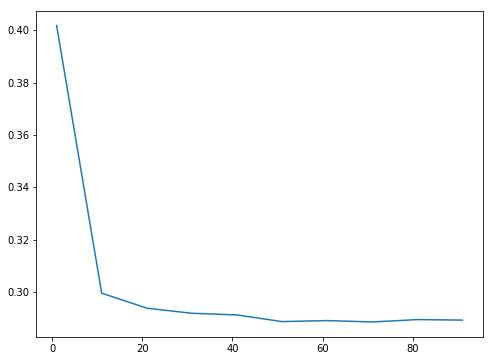

In [383]:
# First find out how many trees are necessary to make reproducible predictions
tree_list = [] # to store the number of trees for each model
cv_rdfr_list = [] # to store the rmse score of each model

for trees in range(1, 100, 10): 
    rdfr = RDFR(n_estimators = trees, max_depth = 20, max_features = 20)
    cv_rdfr = rmse_cv(rdfr).mean()
    tree_list += [trees]
    cv_rdfr_list += [cv_rdfr]

# plot rmse score and tree number
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(tree_list, cv_rdfr_list)
plt.show()

In [384]:
# search for best depth and feature nubmers, we narrowed our search range below to decrease the runnign time of final jupyter notebook
# Actual search range for depth: [1, 2, 3, 5] + range(10, 51, 5)
# Actual search range for feature: range(15, 200, 15)

depth_list = []
feature_list = []
cv_rdfr_list = []
for depth in [5, 10, 15]: 
    for feature in[5, 10, 15]: 
        rdfr = RDFR(n_estimators = 100, max_depth = depth, max_features = feature)
        cv_rdfr = rmse_cv(rdfr).mean()
        depth_list += [depth]
        feature_list += [feature]
        cv_rdfr_list += [cv_rdfr]     

In [385]:
# find best parameters
best_score = min(cv_rdfr_list)
index = cv_rdfr_list.index(best_score)
print("Best depth is {}, best feature number is {}".format(depth_list[index], feature_list[index]))

Best depth is 15, best feature number is 15


In [386]:
# construct best random forest model and important features

rdfr = RDFR(n_estimators = 100, max_depth = 15, max_features = 15) 
rdfr.fit(x_train, y_train)
importances = rdfr.feature_importances_

# To predict use: rdfr.predict(x_test)

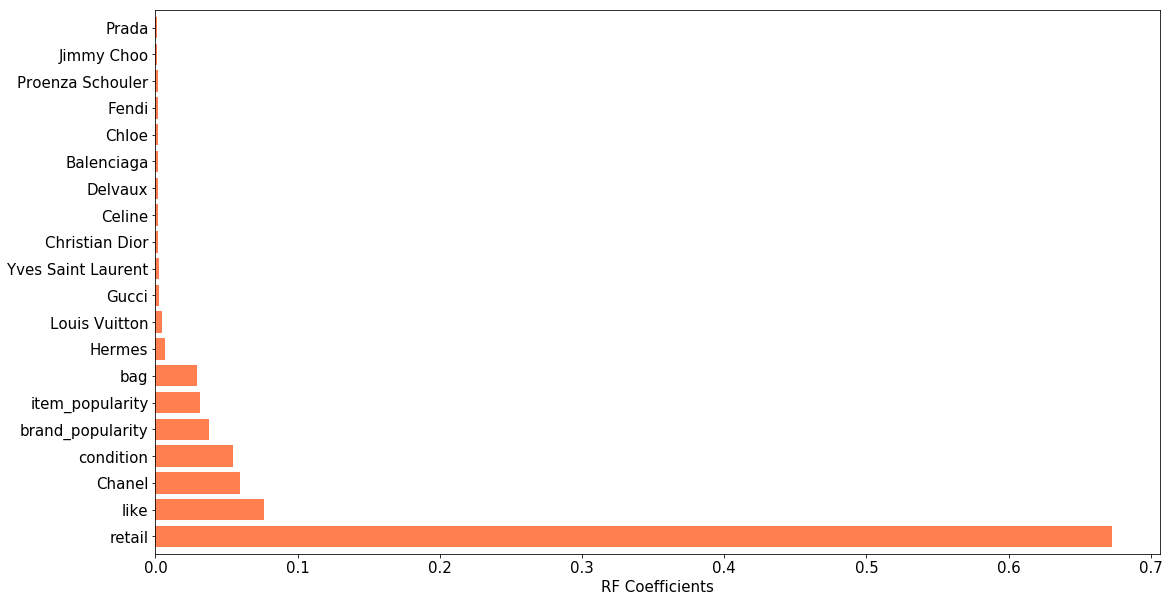

In [232]:
# Plot importance of predictors according to random forest regressor
importances = pd.DataFrame(importances)
importances_sorted = importances.sort_values(by=[0], ascending=[False])
imp_coef = importances_sorted.head(20)
name_index = imp_coef.index.values
feature_index = x_train.columns.values[name_index]
imp_coef.index = feature_index                    

matplotlib.rcParams['figure.figsize'] = (18, 10)
imp_coef.plot(kind = "barh", width = 0.8, color = 'coral', legend=None, fontsize = 15)
plt.xlabel('RF Coefficients', fontsize = 15)
plt.show()

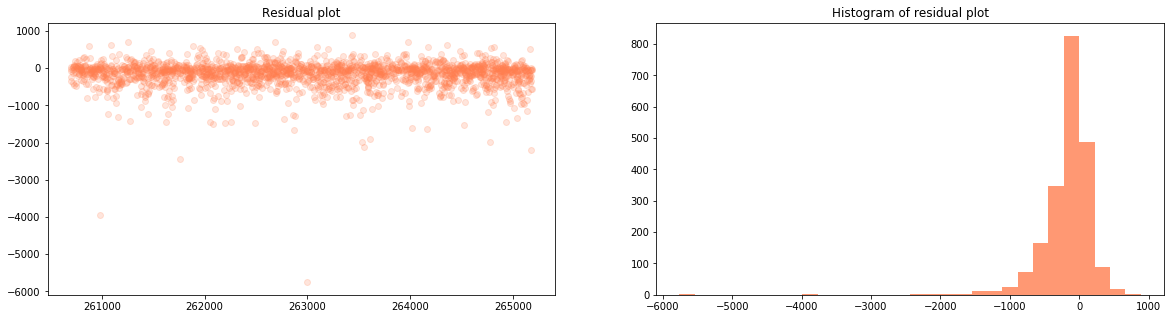

In [387]:
# Predict with our constructed Ridge model
pred = rdfr.predict(x_test)
diff = np.exp(pred) - np.exp(y_test)

f, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 5))
ax1.plot(diff, 'o', color = 'coral', alpha = 0.2)
ax2.hist(diff, bins=30, color = 'coral', alpha = 0.8)
ax1.set_title('Residual plot')
ax2.set_title('Histogram of residual plot')
plt.show()

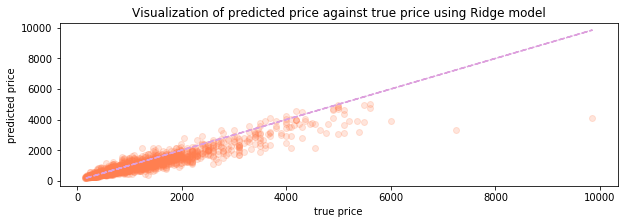

In [388]:
plt.figure(figsize=[10,3])
plt.plot(np.exp(y_test), np.exp(pred), 'o', color = 'coral', alpha = 0.2)
plt.plot(np.exp(y_test), np.exp(y_test),'--', color = 'plum', )
plt.xlabel('true price')
plt.ylabel('predicted price')
plt.title('Visualization of predicted price against true price using Ridge model')
plt.show()

# Business profit analysis using daily bucket

In [568]:
# constants
cc_rate = 0.03 #credit card rate 
shipping = 30 
authentication = 10  

In [569]:
# predict price using pricing model: best_ridge
bucket_pred = np.exp(best_ridge.predict(bucket_full_ready_std))

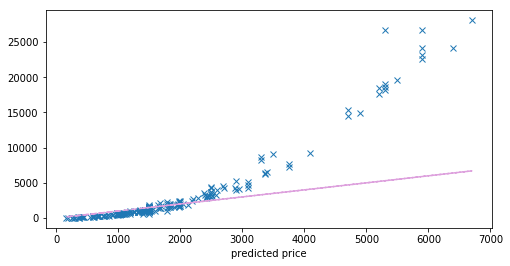

In [570]:
# visualize retail price vs predicted price. predicted price is way off..... 
plt.figure(figsize=[8,4])
plt.plot(np.exp(bucket_full_ready_name['retail']), bucket_pred, 'x')
plt.plot(np.exp(bucket_full_ready_name['retail']), np.exp(bucket_full_ready_name['retail']), '--',color = 'plum')
plt.xlabel('true price')
plt.xlabel('predicted price')
plt.show()

In [571]:
# build a business table containing the following information
business = pd.DataFrame(columns=['name', 'retail', 'pred_price', 'vat', 
                                 'credit_card_charge', 'possible_profit', 
                                 'traveler_pay', 'net_profit'])

# vat here should be the vat return averaged over different countries. 
# the input price on upon calculator should be retail * 0.9 * us_to_euro_conversion_rate

In [572]:
business['name'] = bucket_full_ready_name['name']
business['retail'] = np.exp(bucket_full_ready_name['retail'])
# business['pred_price'] = bucket_pred
business['pred_price'] = business.retail*0.9 # placeholder until model is modified better

In [573]:
# ##### place-holder need to modify #####
# url = 'https://upon.io/vat/calculate-complete?c=ESP,DEU,FRA,ITA&v='
# # url = 'http://localhost:9876/vat/calculate-complete?c=ESP,DEU,FRA,ITA&v='
# usdeur = 0.89

# def get_vat(price):
#     res = requests.get(url + str(int(price * usdeur)))
#     return sum(res.json().values()) / 4 / usdeur

# business['vat'] = business.apply(lambda row: get_vat(row['pred_price']), axis=1)

business['vat'] = business.retail*0.15

In [574]:
business['credit_card_charge'] = round(cc_rate*business['pred_price'],2)
business['possible_profit'] = round((business.pred_price - (business.retail*0.9 - business.vat)
                          - business.credit_card_charge - shipping - authentication),2)
business['traveler_pay'] = business.vat*1.1
business['net_profit'] = round(business.possible_profit - business.traveler_pay, 2)

In [575]:
business

,name,retail,pred_price,vat,credit_card_charge,possible_profit,traveler_pay,net_profit
0,LOUIS VUITTON Monogram Speedy 30,1020.0,918.0,153.00,27.54,85.46,168.300,-82.84
1,LOUIS VUITTON Damier Ebene Speedy 30,1020.0,918.0,153.00,27.54,85.46,168.300,-82.84
2,LOUIS VUITTON Monogram Speedy 25,1000.0,900.0,150.00,27.00,83.00,165.000,-82.00
3,LOUIS VUITTON Monogram Pochette Metis,1830.0,1647.0,274.50,49.41,185.09,301.950,-116.86
4,LOUIS VUITTON Monogram Artsy MM,2000.0,1800.0,300.00,54.00,206.00,330.000,-124.00
5,LOUIS VUITTON Monogram Pochette Accessories,310.0,279.0,46.50,8.37,-1.87,51.150,-53.02
6,LOUIS VUITTON Damier Ebene Neverfull MM,1320.0,1188.0,198.00,35.64,122.36,217.800,-95.44
7,LOUIS VUITTON Monogram Neverfull MM,1050.0,945.0,157.50,28.35,89.15,173.250,-84.10
8,LOUIS VUITTON Damier Ebene Eva Clutch,1500.0,1350.0,225.00,40.50,144.50,247.500,-103.00
9,LOUIS VUITTON Damier Azur Speedy 30,1020.0,918.0,153.00,27.54,85.46,168.300,-82.84


In [576]:
bucket_profit = np.sum(business.net_profit)
print('Daily max profit:', bucket_profit)

Daily max profit: -30131.86


In [577]:
np.sum(business.possible_profit)

46914.9